# Julia quickstart for astronomers

In <em>Optimal frequency-domain analysis for spacecraft time series: Introducing the missing-data multitaper power spectrum estimator</em> (), we argue that the [missing-data multitaper power spectrum estimator](https://docslib.org/doc/8088936/a-multitaper-spectral-estimator-for-time-series-with-missing-data) should replace the Lomb-Scargle periodogram for time series with uniform observing cadence from which some data are missing (<em>Kepler</em>, K2, TESS, etc). <tt>Multitaper.jl</tt>, a publicly available <tt>Julia</tt> package by [Haley & Geoga (2020)](https://joss.theoj.org/papers/10.21105/joss.02463), implements all of the methods demonstrated in the paper. <tt>Julia</tt> is an ideal language for Fourier analysis because of its fast matrix operations.

This notebook uses radial velocities and V-band photometry of Proxima Centauri to demonstrate basic <tt>Julia</tt> functionality that will get astronomers up and running. The emphasis is on interacting with data, not on computer science principles. After working through this notebook, you'll have enough "pidgin" <tt>Julia</tt> to do some science, and you'll understand a lot of [StackOverflow's](https://stackoverflow.com) <tt>Julia</tt> content. 

### Installing <tt>iJulia</tt> and integrating with <tt>Jupyter</tt> notebook

To get <tt>Julia</tt> working in <tt>Jupyter</tt>, I followed [these instructions](https://datatofish.com/add-julia-to-jupyter/).

### Packages

As in <tt>python</tt>, most of your workflow will rely on external packages rather than the core language. When you're getting started, expect lots of warnings about packages not being installed. Fortunately, both command-line <tt>Julia</tt> and <tt>iJulia</tt> will tell you exactly how to install each missing package. Try installing <tt>Multitaper.jl</tt> with

<tt>import Pkg; Pkg.add("Multitaper")</tt>

To load packages, you can call either <tt>import</tt> or <tt>using</tt>. <tt>Julia</tt>'s <tt>import</tt> behaves like python's:

<tt>import Statistics</tt><br />
<tt>println(Statistics.mean([1, 4, 6, 8, 11]))</tt>

<tt>using</tt> behaves like <tt>python</tt>'s<br />
<tt>from package import *</tt>:

<tt>using Statistics</tt><br />
<tt>println(mean([1, 4, 6, 8, 11]))</tt>

## Begin tutorial

### Load packages needed for this demo

[DelimitedFiles](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/): similar to <tt>numpy.loadtxt()</tt>, a simple text file reader that loads data into a matrix<br />
[CSV](https://juliapackages.com/p/csv): a more sophisticated file reader that is designed for CSV files, but can also handle whitespace and other delimiters<br />
[DataFrames](https://juliapackages.com/p/dataframes): <tt>pandas</tt>-like package for handling data frames written in <tt>Julia</tt> (note that [Pandas.jl](https://www.juliapackages.com/p/pandas) is a <tt>Julia</tt> interface to the actual <tt>python pandas</tt> package<br />
[Plots](https://docs.juliaplots.org/latest/): a slow but powerful plotting package that produces publication-quality plots without much effort on your part<br />
[Statistics](https://docs.julialang.org/en/v1/stdlib/Statistics/): a standard library that performs basic statistical calculations (mean, median, standard deviation, etc.)<br />
[LombScargle](http://juliaastro.org/LombScargle.jl/stable/): same algorithm as in <tt>astropy.timeseries.LombScargle</tt> and almost the same functionality<br />
[StatsBase](https://juliastats.org/StatsBase.jl/stable/): calculates commonly used statistics such as moments, (auto)covariances, and number of items in a collection<br />
[LaTeXStrings](https://www.juliapackages.com/p/latexstrings): easy way to construct plot labels using LaTeX syntax<br />
[Polynomials](https://www.juliapackages.com/p/polynomials): lightweight package for polynomial arithmetic<br />

<strong>Unlike <tt>python</tt>, <tt>Julia</tt> is a compiled language:</strong> each code block you write is "just-in-time" compiled before it's executed. What this means for your workflow is that <tt>Julia</tt> is slow to get going, because it's going to pre-compile most of the code in the packages you load. But the slow start is usually worth it, because you save time on heavy-duty calculations later. So take a walk around the block while you wait for the next cell to execute, then come back re-invigorated and ready to compute.

In [1]:
using DelimitedFiles, CSV, DataFrames, Plots, Statistics, LombScargle, StatsBase, 
      LaTeXStrings, Polynomials

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


### Read in radial velocities of Proxima Centauri [(Suarez Mascareno et al. 2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...639A..77S/abstract)

<tt>skipstart=39</tt> makes <tt>readdlm()</tt> skip the first 39 lines of the file: all those lines are comments/header, but not all start with #.<br />
<tt>comments=true</tt> tells <tt>readdlm()</tt> to ignore any other lines starting with # (you can change the comment character).<br />
By default, <tt>readdlm()</tt> will skip blank lines.

In [2]:
Proxima_RVdata = readdlm("Proxima_RV_SuarezMascareno2020.txt", skipstart=39, comments=true)

334×4 Matrix{Float64}:
 1634.73   3.41  0.6   0.0
 1654.61   0.18  0.72  0.0
 1681.78  -2.72  0.75  0.0
 1688.55   2.32  0.59  0.0
 1707.62   0.16  0.57  0.0
 1737.53  -1.85  0.79  0.0
 1740.58   1.58  0.67  0.0
 1761.55  -1.2   0.51  0.0
 1818.5   -1.57  0.73  0.0
 1919.84  -0.28  0.58  0.0
 1946.81  -0.07  0.6   0.0
 2118.52  -0.71  0.7   0.0
 2119.5   -2.11  0.69  0.0
    ⋮                  
 8688.51   5.26  0.3   4.0
 8700.57   2.62  0.28  4.0
 8706.49  -0.54  0.21  4.0
 8716.5   -0.15  0.2   4.0
 8718.51  -0.02  0.27  4.0
 8720.5    1.91  0.29  4.0
 8726.49   0.91  0.38  4.0
 8731.49   2.94  0.21  4.0
 8737.48   1.17  0.26  4.0
 8741.47   0.0   0.25  4.0
 8752.48   1.53  0.48  4.0
 8753.47   2.0   0.23  4.0

### Turn timestamp, magnitude, and error columns into vectors

Here you encounter one of the most appealing features of <tt>Julia</tt>: its array indices start at one, not at zero. No more remembering that in <tt>python</tt>, <tt>range(10)</tt> doesn't actually include 10. Like python, 2-d array indexing is \[row, column\].

At some point, you will have to deal with the fact that <tt>Julia</tt> is stricter about data types than <tt>python</tt>. This is because there's a considerable speed enhancement when the variable type can be inferred at compile time. For this tutorial, the relevant point is that <tt>Julia</tt> considers a matrix and a vector to be different data types. To figure out a variable's type, use <tt>typeof()</tt>. <tt>println()</tt> starts a new line, then prints your output. 

In [3]:
time = Proxima_RVdata[:,1] # Arrays are one-indexed!
RV = Proxima_RVdata[:,2]
RVerr = Proxima_RVdata[:,3]

println(typeof(Proxima_RVdata))
println(typeof(time))

Matrix{Float64}
Vector{Float64}


### Sort the time series by date

VizieR sorts the data by instrument instead of timestamp.

In [4]:
inds = sortperm(time)
time = time[inds]
RV = RV[inds]
RVerr = RVerr[inds]

334-element Vector{Float64}:
 0.6
 0.72
 0.75
 0.59
 0.57
 0.79
 0.67
 0.51
 0.73
 0.58
 0.6
 0.7
 0.69
 ⋮
 0.3
 0.28
 0.21
 0.2
 0.27
 0.29
 0.38
 0.21
 0.26
 0.25
 0.48
 0.23

### Shift timestamps so that t\[1\] = 0

No matter what language I'm using, I always do this. For some older software, the bit depth of a Julian date is high enough to trigger a segmentation fault. Even if that's not the case, or if timestamps are in some other unit besides JD, most statistics literature assumes time series start at t = 0. One exception is the Lomb-Scargle periodogram, which the tau parameter ensures is shift-invariant.

<strong>Here you need the broadcast operator:</strong> unlike <tt>python</tt>, <tt>Julia</tt> will not automatically vectorize computations for you. (This is related to the type strictness issue.) Thus,<br />
<tt>time = time - time[1]</tt><br />
won't work, because you can't subtract a scalar from a vector. <em>You have to explicitly tell <tt>Julia</tt> to apply the subtraction to every element in the vector.</em> You can do this with the broadcast operator, a dot: <tt>.</tt> 

In [5]:
time = time .- time[1]

334-element Vector{Float64}:
    0.0
   19.883000000000038
   47.044000000000096
   53.817999999999984
   72.894
  102.79899999999998
  105.84699999999998
  126.82099999999991
  183.76800000000003
  285.11300000000006
  312.077
  483.78599999999983
  484.769
    ⋮
 7053.784
 7065.834000000001
 7071.763000000001
 7081.773999999999
 7083.781000000001
 7085.766
 7091.754000000001
 7096.754000000001
 7102.753000000001
 7106.741
 7117.745000000001
 7118.743

### Plot the Proxima Centauri RVs

<tt>Plots</tt> is slow to produce your first plot, but subsequent plots are much quicker. Even though I'm often impatient for my plot to appear, I've concluded that <tt>Julia Plots</tt> is worth the wait. You'll get publication-quality plots with less work than in <tt>matplotlib.pyplot</tt> (which is also great, don't get me wrong). The syntax for <tt>Plots</tt> is like a <tt>python-IDL</tt> hybrid: you can provide keywords in the call to <tt>plot()</tt> or <tt>scatter()</tt> to customize your <em>entire</em> plot, not just one series, but you can also modify the plot object after you create it. Bonus: if you save your plot object with <tt>myplot = plot()</tt>, you can easily combine it with other plots later.

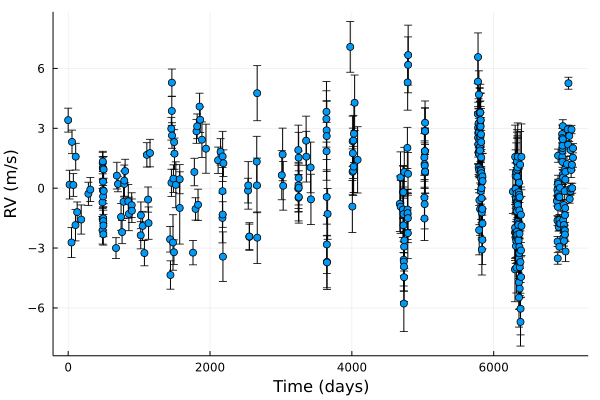

In [6]:
RV_plot = scatter(time, RV, yerr=RVerr, xlabel="Time (days)", 
                  ylabel="RV (m/s)", legend=false)

### Find the indices of the final three high-cadence observing seasons (time > 5500 days)

Let's examine the high-cadence data in last three observing seasons more closely. We could zoom into those on the plot by setting <tt>xlim=(5500,6600)</tt> in the call to <tt>scatter()</tt>, but later we'll do some math with the high-cadence data, so we need to find the relevant array indices.

Notice that we need to broadcast the greater-than operator, since we can't compare a scalar and a vector directly.

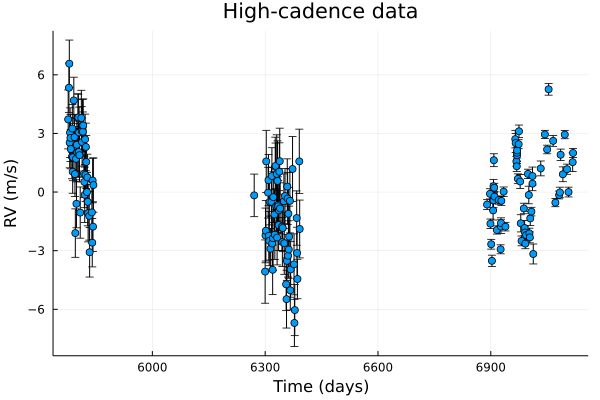

In [7]:
late = findall(time .>  5500)

scatter(time[late], RV[late], yerr=RVerr[late], xlabel="Time (days)", 
        ylabel="RV (m/s)", title="High-cadence data", legend=false)

### Compare the variance of the time series with the mean-squared error bar

This is a quick-and-dirty check of whether the variance in the time series could be subsumed by the error bars. If not, it's less likely that signals in the frequency domain are spurious. Here the variability can't easily be explained by random error.

In [8]:
println("Time series variance: $(var(RV)) m^2/s^2")

# Notice the broadcast operator before the caret
println("Mean-squared error bar: $(mean(RVerr .^2)) m^2/s^2")

Time series variance: 5.374459739979501 m^2/s^2
Mean-squared error bar: 1.1386455089820358 m^2/s^2


### Examine measures of center and histogram of the time steps dt

I do this to figure out the maximum frequency I can reasonably probe. The * in the <tt>xlabel</tt> is used to concatenate strings. Since we loaded the LaTeXStrings package, strings with L just before the first quotation mark are interpreted as LaTeX syntax.

Note the broadcast operator in <tt>log10.()</tt>: if you try <tt>log10(dt)</tt> without the dot, you'll get an error.

Mean dt: 21.37760660660661 days
Median dt: 1.9329999999999927 days


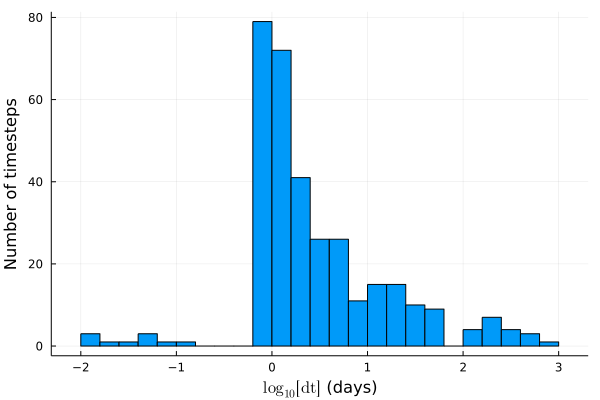

In [9]:
dt = diff(time) # Same as numpy.diff()
println("Mean dt: $(mean(dt)) days")
println("Median dt: $(median(dt)) days")

Proxima_dthist = histogram(log10.(dt), 
                           xlabel=L"\log_{10}[\mathrm{dt}]"*" (days)", 
                           ylabel="Number of timesteps", legend=false) 

### Compute and plot the Lomb-Scargle periodogram

The workflow is similar to <tt>astropy.timeseries.LombScargle</tt>: we compute a periodogram object, then use it to calculate a false alarm threshold.

<strong>Don't let the word "object" confuse you:</strong> <tt>Julia</tt> does not support object-oriented programming the way <tt>python</tt> does. [In <tt>Julia</tt>, you can't embed a method <em>inside</em> a type definition.](https://stackoverflow.com/questions/33755737/julia-oop-or-not) Instead, "object" is shorthand for a derived type (a C-like structure), and methods operate <em>on</em> types instead of belonging to types.

In [10]:
RV_pgram = lombscargle(time, RV, RVerr)
RV_freq, RV_pow = freqpower(RV_pgram)
RV_fal01 = fapinv(RV_pgram, 0.01)

0.06615348662971032

To plot the 1% false alarm threshold and the frequency of the planet orbit, we use the <tt>!</tt> syntax to modify the existing plot. In general, <tt>!</tt> tells the compiler to operate "in place" instead of returning a new object. You'll notice in the documentation that lots of functions have in-place versions, as in [unique() and unique!()](https://docs.julialang.org/en/v1/base/collections/)

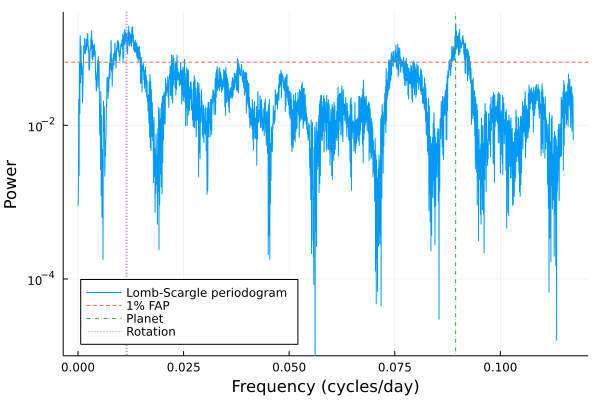

In [11]:
planet = 1/11.18427 # cycles/day
rotation = 1/87

Proxima_LombScargle_plot = plot(RV_freq, RV_pow, 
                                xlabel="Frequency (cycles/day)", ylabel="Power",
                                label="Lomb-Scargle periodogram", yscale=:log10, 
                                legend=:bottomleft, ylim=(1e-5,0.3))
hline!([RV_fal01], label="1% FAP", linestyle=:dash)
vline!([planet], label="Planet", linestyle=:dashdot)
vline!([rotation], label="Rotation", linestyle=:dot, lw=2)

### Make a two-panel plot containing the Proxima Cen RV time series and its Lomb-Scargle periodogram

Here we use one of the most appealing features of <tt>Plots</tt>: the ability to easily tile together individual plot windows to make a multi-panel figure.

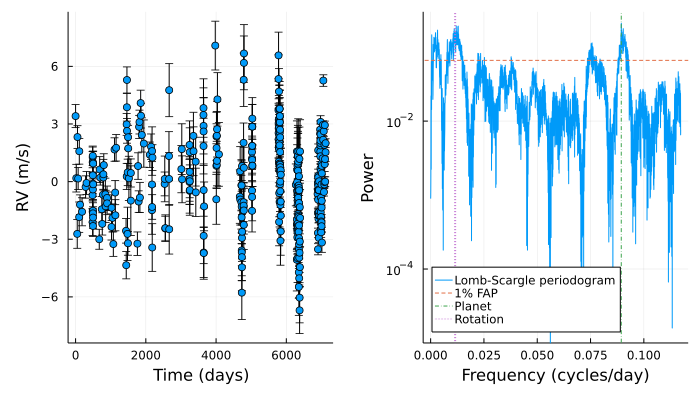

In [12]:
# Make a multi-panel plot with one row and two columns, using a wide plot window 
#    specified by wsize

# Note: If part of your axis labels get cut off when you combine plots, use the 
#    margin keywords to add extra space

plot(RV_plot, Proxima_LombScargle_plot, layout=(1,2), wsize=(700,400), 
     bottom_margin=5Plots.mm, left_margin=5Plots.mm)

### Examine the pseudowindows at the planet's orbital frequency and the rotation frequency

As explained by [Scargle (1982)](https://ui.adsabs.harvard.edu/abs/1982ApJ...263..835S/abstract) and discussed further by Dodson-Robinson and Haley (2022), the Lomb-Scargle spectral window is not the same at all frequencies. Here we will examine the pseudowindow at the planet's orbital frequency fp, which can be estimated by the Lomb-Scargle periodogram of a sinusoid with frequency fp, and the pseudowindow at the rotation frequency.

The splat operator <tt>...</tt> unpacks a tuple. Recall that <tt>freqpower()</tt> returns a tuple of two vectors; by using the splat, we don't have to assign the vectors to their own variables before making the plot.

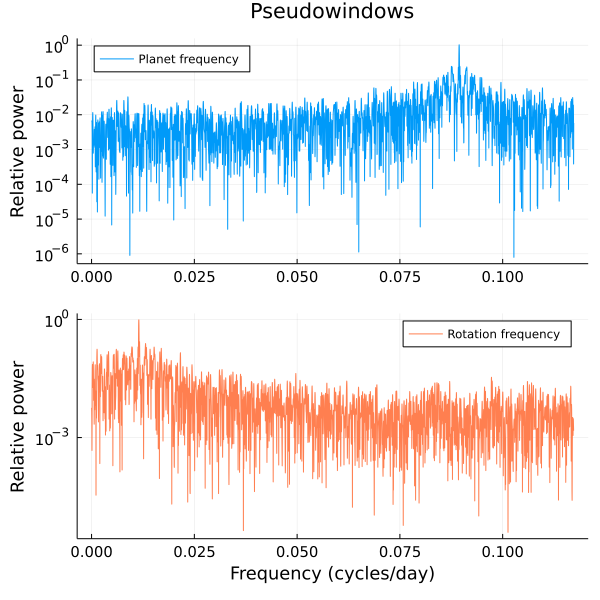

In [13]:
# In the plot, guidefontsize is for the x & y axis labels and 
# tickfontsize is for the tick labels. Plots uses X11 colors.

pl_pseudo = plot(freqpower(lombscargle(time, sin.(2*pi*planet*time)))..., 
                 label="Planet frequency", guidefontsize=12, 
                 tickfontsize=10, yscale=:log10, title="Pseudowindows", 
                 ylabel="Relative power", legend=:topleft)

rot_pseudo = plot(freqpower(lombscargle(time, sin.(2*pi*rotation*time)))...,
                  label="Rotation frequency", guidefontsize=12, 
                  tickfontsize=10, yscale=:log10, 
                  xlabel="Frequency (cycles/day)", color=:coral, 
                  ylabel="Relative power")

plot(pl_pseudo, rot_pseudo, layout=(2,1), wsize=(600,600))

### Examine the high-cadence data separately

The observation times and dates strongly shape the pseudowindows. Let's look at the frequency-domain representation of the last three observing runs, which have high cadence but are concentrated in time. The results are qualitatively the same as what we got from the entire dataset, but the periodogram and pseudowindows have less "grass" and more ringing.

For the pseudowindow analysis, we'll use <tt>map()</tt> with a "stabby lambda" (similar to a lambda function in <tt>python</tt>) instead of a broadcasted <tt>sin.()</tt>. Here <tt>map()</tt> and the broadcast operator do the same thing, but [that won't always be true](https://stackoverflow.com/questions/52892726/julia-whats-the-difference-between-map-and-broadcast). [The broadcast operator wasn't introduced until <tt>Julia</tt> 0.6](https://julialang.org/blog/2017/01/moredots/), so you'll run into [<tt>map()</tt>](https://docs.julialang.org/en/v1/base/collections/index.html#Base.map) a lot if you're reading StackOverflow or GitHub repos.

In [14]:
 # Note the specification of the Nyquist factor
RV_pgram_late = lombscargle(time[late], RV[late], RVerr[late], 
                            nyquist_factor=3)
RV_freq_late, RV_pow_late = freqpower(RV_pgram_late)
RV_fal01_late = fapinv(RV_pgram_late, 0.01)

0.11436013568910963

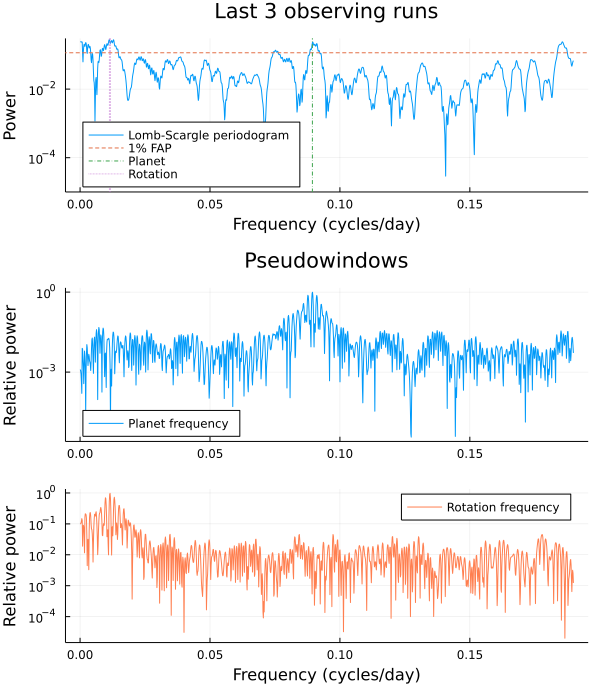

In [15]:
Proxima_LS_pl_late = plot(RV_freq_late, RV_pow_late, 
                          xlabel="Frequency (cycles/day)", 
                          ylabel="Power", label="Lomb-Scargle periodogram", 
                          yscale=:log10, legend=:bottomleft, 
                        ylim=(1e-5,0.3), title="Last 3 observing runs")
hline!([RV_fal01_late], label="1% FAP", linestyle=:dash)
vline!([planet], label="Planet", linestyle=:dashdot)
vline!([rotation], label="Rotation", linestyle=:dot, lw=2)

pl_ps_late = plot(freqpower(lombscargle(time[late], 
                  map(t -> sin(2*pi*planet*t), time[late]), nyquist_factor=3))..., 
                  label="Planet frequency", yscale=:log10, title="Pseudowindows", 
                  ylabel="Relative power", legend=:bottomleft)

rot_ps_late = plot(freqpower(lombscargle(time[late], 
                   map(t -> sin(2*pi*rotation*t), time[late]), nyquist_factor=3))..., 
                   label="Rotation frequency", yscale=:log10, 
                   xlabel="Frequency (cycles/day)", color=:coral, 
                   ylabel="Relative power")

# Note the (3 rows, 1 column) plot layout
plot(Proxima_LS_pl_late, pl_ps_late, rot_ps_late, layout=(3,1), wsize=(600,700))

### Explore [ASAS observations](http://www.astrouw.edu.pl/asas/) of Proxima Centauri using <tt>DataFrames</tt>

To analyze more complex datasets, we turn to the <tt>pandas</tt>-like functionality in <tt>DataFrames</tt>, which has filtering capabilities that are helpful for data with varying quality grades and/or missing values. The ASAS V-band observations have A-D data quality ratings and missing values denoted either 29.999 or 99.999.

Here we will use a CSV reader to parse the input file, then create a data frame and operate on its columns. In the next cell, we have to specify that the read() function we want belongs to CSV, since Julia core also has read(). Adding DataFrame in the call to CSV.read() gives the <tt>DataFrames</tt> package direct control of the output. We use the keyword <tt>missingstring</tt> to tell <tt>CSV.read()</tt> that 29.999 and 99.999 stand in for missing values. 

In [16]:
hdr = [:hjd, :mag1, :mag0, :mag2, :mag3, :mag4, 
       :mer1, :mer0, :mer2, :mer3, :mer4, :grade, :frame]

# delim=" ", ignorerepeated=true is like delim_whitespace=True in pandas
asas = CSV.read("Proxima_ASAS.txt", DataFrame; header=hdr,
                comment="#", delim=" ", ignorerepeated=true, 
                missingstring=["29.999", "99.999"])

,hjd,mag1,mag0,mag2,mag3,mag4,mer1,mer0,mer2
,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64,Float64
1,2140.48,11.23,11.21,11.238,11.257,11.303,0.042,0.055,0.045
2,1966.79,11.317,11.289,11.341,11.392,11.416,0.045,0.046,0.035
3,1967.82,11.285,11.291,11.319,11.373,11.388,0.044,0.044,0.035
4,1971.8,11.272,11.263,11.336,11.402,11.435,0.051,0.052,0.04
5,1985.74,11.238,11.279,11.254,11.304,11.336,0.054,0.056,0.044
6,2787.72,12.237,12.287,11.873,11.625,11.56,0.04,0.045,0.035
7,2882.52,missing,missing,missing,missing,missing,0.045,0.052,0.04
8,3772.8,missing,missing,missing,missing,missing,0.046,0.056,0.044
9,3906.56,missing,missing,missing,missing,missing,0.048,0.06,0.043


### Sort the data frame by HJD and reject the D-quality photometry with <tt>filter()</tt>.

To work on the existing data frame rather than create new data frames with each operation, we use the in-place operator <tt>!</tt>.

In [17]:
sort!(asas, :hjd)
println("# observations before filtering out D-quality data: $(nrow(asas))")
filter!(:grade => !=("D"), asas)
println("# observations after filtering out D-quality data: $(nrow(asas))")

# observations before filtering out D-quality data: 1222
# observations after filtering out D-quality data: 1148


### Plot mag1 as a function of time (HJD)

mag0, mag1, etc. are different magnitude measurements made from different aperture sizes. The optimal aperture size depends on the brightness of the target.

<strong>Warning: Beware of data-intensive scatter plots.</strong> In my experience, making multiple scatter plots with thousands of data points each will noticeably slow down your notebook. I suspect there is a memory leak in either <tt>Plots</tt> or <tt>iJulia</tt>. If you decide to scatter-plot <em>all</em> of the photometry from each ASAS aperture, plus a few <em>Kepler</em> time series, you might run into performance problems. Line plots seem to be much less memory intensive, but they don't make sense for time series with nonuniform observing cadence.

If scatter plots are bugging you, you could try using the REPL (read-execute-print loop, which is a fancy way of describing the <tt>Julia</tt> terminal) or <tt>Pluto</tt>, a notebook written in <tt>Julia</tt> for <tt>Julia</tt>. <tt>Pluto</tt> is nice, but I prefer <tt>Jupyter</tt> for reasons that require more explanation than I want to include in this notebook.

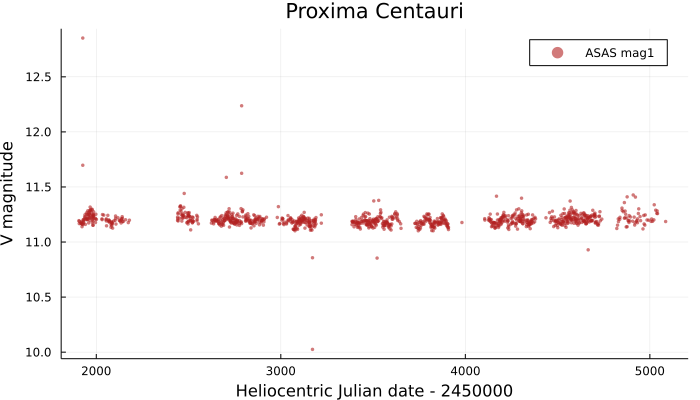

In [18]:
asas_mag1_plot = scatter(asas.hjd, asas.mag1, markersize=2, 
                         markerstrokewidth=0, alpha=0.6, color=:firebrick,
                         xlabel="Heliocentric Julian date - 2450000", 
                         ylabel="V magnitude", title="Proxima Centauri",
                         label="ASAS mag1", wsize=(700,400))

### Reject outliers

Our plot of mag1 shows that there are outliers, so let's do a 3-sigma clip. Here we run into <tt>Julia</tt>'s specificity about types: If you try to find the indices of the good data points with<br />
<tt>good_data = findall(abs.(asas.mag1 .- mean(asas.mag1)) .< 3*std(asas.mag1))</tt>,<br />
you'll get the following error:<br />
    <tt>TypeError: non-boolean (Missing) used in boolean context</tt><br />
    This is because <tt>missing</tt> is a different data type than <tt>Float64</tt>, not a stand-in for <tt>Float64</tt>. 
    
To do the sigma clipping, we will first identify non-missing mag1 values by mapping <tt>!ismissing()</tt> (<tt>!</tt> is the negation operator) onto the mag1 column of our asas data frame. Then we will use <tt>collect(skipmissing())</tt> to turn the remaining mag1 data into a Float64 vector, which cannot hold missing values.
    We need <tt>collect()</tt> because <tt>skipmissing()</tt> just returns an iterator instead of the actual data. <tt>collect()</tt> puts the data into a vector that we can use in calculations. You can also use <tt>collect()</tt> to create a vector out of a range, as in <tt>v = collect(1:10)</tt>.

In [28]:
"""Drop missing values"""

# ismissing() returns Boolean
notmissing = map(i -> !ismissing(i), asas.mag1)  
mag1 = collect(skipmissing(asas.mag1))
hjd = asas.hjd[notmissing]

println("Type of DataFrame column asas.mag1: ", typeof(asas.mag1))
println("Type of mag1: ", typeof(mag1))

"""Sigma clip"""
# absolute value function, subtraction, and less-than are broadcast
good_data = findall(abs.(mag1 .- mean(mag1)) .< 3*std(mag1))
hjd = hjd[good_data]
mag1 = mag1[good_data]

Type of DataFrame column asas.mag1: SentinelArrays.SentinelVector{Float64, Float64, Missing, Vector{Float64}}
Type of mag1: Vector{Float64}


1065-element Vector{Float64}:
 11.194
 11.188
 11.167
 11.17
 11.172
 11.164
 11.186
 11.177
 11.139
 11.163
 11.158
 11.202
 11.18
  ⋮
 11.2
 11.198
 11.187
 11.209
 11.188
 11.201
 11.338
 11.289
 11.26
 11.282
 11.258
 11.186

We'll plot the results of the 3-sigma clipping after removing data with duplicate time stamps and fitting a long-term trend.

### Check for repeated time stamps

Occasionally ASAS data will have two or more measurements with the same time stamp. For Fourier analysis, we don't want any repeated time stamps. Below, <tt>diff()</tt> is analogous to <tt>numpy.diff()</tt>.

In [29]:
# If output is zero, there is at least one repeat
println("Minimum timestep dt (days): ", minimum(diff(hjd)))

Minimum timestep dt (days): 0.0


### Average measurements with identical time stamps

<p>Now that we know we have repeated time stamps, we'll write a function to average their measurements. If this were a quick-and-dirty notebook for my eyes only and I didn't plan to reuse or pass on the code, I might write a bare-bones function call like<br />
<pre><tt>function remove_repeats(t, x)
  ...
  ...
end</tt></pre>
Here we'll write a nicer function that specifies argument types and exits gracefully if <tt>t</tt> and <tt>x</tt> are not same-length vectors, or if no repeats are found.</p>

<p>Some pointers for writing functions:

<ul>
<li>Unlike <tt>python</tt>, there are no indentation or whitespace requirements. You can use whatever indentation scheme you prefer.</li>
<li><a href="https://stackoverflow.com/questions/38936868/in-julia-functions-passed-by-reference-or-value">Immutable objects such as Int64 and Float64 scalars are passed by value, while mutable objects like arrays and composite types are passed by reference.</a></li>
<li>Specifying the acceptable argument type(s) in the function call makes the code more efficient. If more than one type is acceptable -- as for our time vector <tt>t</tt>, which could sensibly be either integer or floating point -- you can specify that with <tt>Union{type1, type2, ...}</tt>.</li>
</ul>
    See the <a href="https://docs.julialang.org/en/v1/manual/style-guide/">Julia style guide</a> for further guidance.<p/>

<p><em>Dictionaries:</em> To find repeated time stamps, we use <tt>StatsBase.countmap()</tt>, which creates a dictionary that records the number of times a value occurs in an array. In the loop setup below, the dictionary keys <tt>k</tt> are the timestamps and the value at each key <tt>v</tt> is the number of times that timestamp occurs in the data set. The syntax<br />
<tt>for (k, v) in cm</tt><br />
loops through all key-value pairs. You can get an individual iterator for either the keys or the values with<br />
<tt>value_iterator = values(my_dict)</tt> or <tt>key_iterator = keys(my_dict)</tt><br />
To construct your own dictionary, you can use<br />
<a href="https://docs.julialang.org/en/v1/base/collections/"><tt>my_dict = Dict("A"=>1, "B"=>2)</tt></a><br />
Then, as in <tt>python</tt>, <br />
<tt>my_dict["A"]</tt><br />
will return 1. Keys don't have to be strings: <tt>Dict(1=>11, 2=>22)</tt> and <tt>Dict(1.1=>11.1, 2.2=>22.2)</tt> are perfectly valid.</p>

In [35]:
# In the function call, t = timestamps, x = measurements
function remove_repeats(t::Union{Vector{Float64}, Vector{Int64}}, 
                        x::Vector{Float64})
    
    if length(t) != length(x)
        println("Vectors of timestamps and measurements must have the same length. Exiting...")
        return
    end # Julia if statements must have end statements

    cm = countmap(t)
    
    # Return if no repeats are found, otherwise average repeats
    if (maximum(values(cm)) == 1)
        println("No repeats found")
        return
    else
        println("Repeats found")
    end
        
    for (k, v) in cm
        if (v > 1)
            # In the next line, we broadcast the equality-testing operator
            repeat_inds = findall(t .== k)
            x[repeat_inds[1]] = mean(x[repeat_inds])
            
            # ! makes deleteat() operate in-place: it performs element 
            #    deletion on existing array instead of returning a new array
            map(ind -> deleteat!(t, ind), repeat_inds[2:end])
            map(ind -> deleteat!(x, ind), repeat_inds[2:end])
        end 
    end  # All Julia loops must have end statements
    
end 

# No need to return t and x since they were passed by reference, 
#     meaning their modifications propagate back
#     to the code that called remove_repeats() 

remove_repeats (generic function with 1 method)

In [36]:
println("Before removing repeats: minimum timestep = ", minimum(diff(hjd)), " days")
remove_repeats(hjd, mag1)
println("After removing repeats: minimum timestep = ", minimum(diff(hjd)), " days")

Before removing repeats: minimum timestep = 0.0 days
Repeats found
After removing repeats: minimum timestep = 0.0024899999998524436 days


### Fit long-term trend to the data

In Fourier analysis, long-term trends add power low-frequency power that can leak into higher frequencies, so it's helpful to remove them. Here we'll use <tt>Julia</tt>'s native least-squares operator, a backslash, to find the best-fit coefficients of a cubic polynomial. The syntax [column1 column2 column3] etc constructs a matrix by horizontally concatenating the columns. Note that we could get the same fit with <tt>Polynomials.fit()</tt>, but it's useful to have a demo of linear least-squares functionality, which is general enough to fit any linear combination of functions.

In [37]:
design_matrix = [ones(length(hjd)) hjd hjd.^2 hjd.^3]

# Least-squares fit of y = a + bx + cx^2 + dx^3 where x = hjd and y = mag1
poly_coeffs = design_matrix \ mag1

 # Polynomial() creates a function from polynomial coefficients
trend = Polynomial(poly_coeffs)
print("Coefficients of cubic long-term trend: ", poly_coeffs)

Coefficients of cubic long-term trend: [11.099426744951472, 0.00016061076131017137, -6.779335036464231e-8, 8.267364712795688e-12]

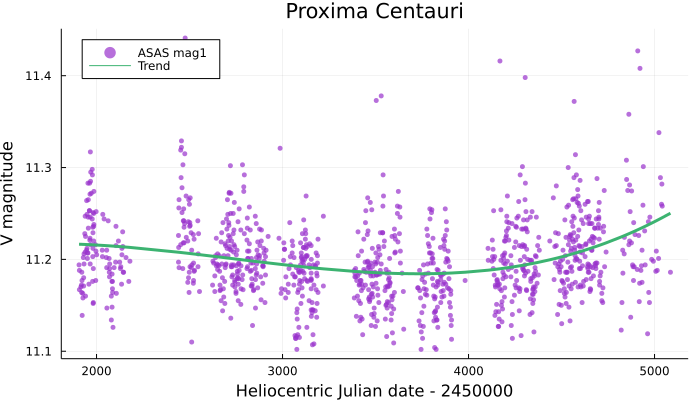

In [38]:
asas_mag1_plottrend = scatter(hjd, mag1, markersize=3, markerstrokewidth=0, 
                              alpha=0.7, color=:darkorchid, 
                              xlabel="Heliocentric Julian date - 2450000",
                              ylabel="V magnitude", title="Proxima Centauri",
                              label="ASAS mag1", wsize=(700,400), legend=:topleft)

# Note the dot: we have to broadcast our trend() function
plot!(hjd, trend.(hjd), color=:mediumseagreen, lw=3, label="Trend")

### Examine the ASAS timestep distribution.

In the histogram below, we see that the bin covering 1--3 days is the most populated. In our Fourier analysis, we'll treat the dataset as if it has a characteristic timestep of 1 day.

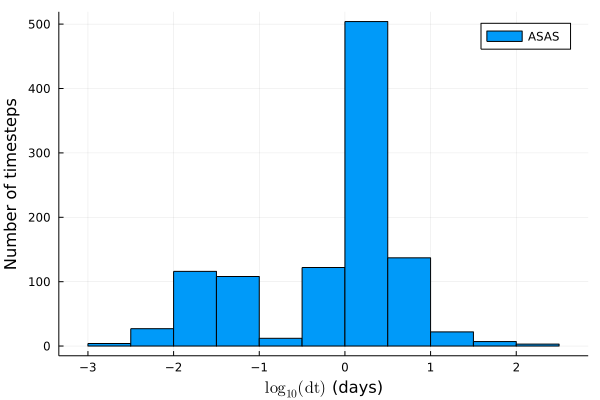

In [39]:
histogram(log10.(diff(hjd)), xlabel=L"\log_{10}(\mathrm{dt}) "*" (days)", 
          ylabel="Number of timesteps", label="ASAS")

### Calculate a Lomb-Scargle periodogram of the trend-subtracted ASAS data using a specified frequency grid

For a characteristic timestep of 1 day, we should set the maximum frequency in our grid (the Nyquist-like frequency) to 0.5 cycles/day. We use <tt>LinRange(start, stop, num_points)</tt> to specify the grid. The resulting <tt>LinRange</tt> data type is quite lightweight, as the computer can merely store the start, step, and stop values instead of populating a vector. However, we can use <tt>collect()</tt> to turn the <tt>LinRange</tt> into a vector if necessary.

The natural resolution of our periodogram is 1/[maximum(t) - minimum(t)], i.e., the inverse of the time baseline. We're going to oversample the grid by a factor of 4 in order to interpolate our Lomb-Scargle periodogram.

Although by default <tt>round()</tt> gives the nearest integer, its return type is <tt>Float64</tt>, so we wrap the result of <tt>round</tt> in <tt>Int64</tt> to pass <tt>LinRange()</tt> an integer number of data points. You can set the <tt>digits</tt> keyword in <tt>round()</tt> to find the nearest tenth, hundredth, etc.

In [40]:
# The next line shifts the time vector so the first time stamp is zero. 
# It's not necessary for Lomb-Scargle specifically,
# but it can be important for other frequency domain algorithms
t_asas = hjd .- hjd[1]

# detrend
mag1_detrended = mag1 .- trend.(hjd)

# t_asas[end] is like t_asas[-1] in python: it returns the last value in the vector
resolution = 1/t_asas[end]
oversample = 4
Nyquist_like = 0.5
n_gridpoints = Int64(round(oversample * Nyquist_like / resolution))
asas_fgrid = LinRange(resolution/oversample, 0.5, n_gridpoints)

# Call lombscargle(), passing in our frequency grid
asas_pgram = lombscargle(t_asas, mag1_detrended, frequencies=asas_fgrid)
asas_pow = LombScargle.power(asas_pgram)
asas_fal01 = fapinv(asas_pgram, 0.01)

0.02233430039060247

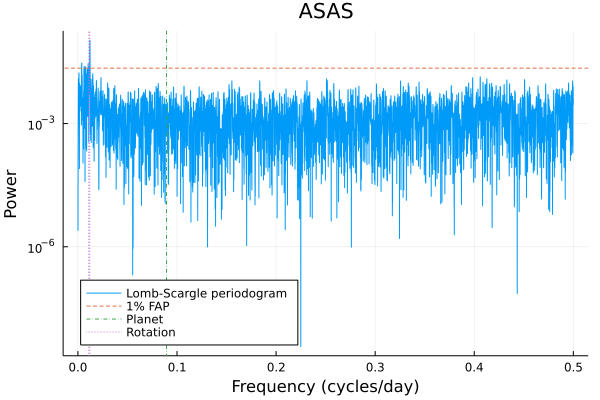

In [41]:
ASAS_LombScargle_plot = plot(asas_fgrid, asas_pow, xlabel="Frequency (cycles/day)", 
                             ylabel="Power", label="Lomb-Scargle periodogram", 
                             yscale=:log10, legend=:bottomleft, title="ASAS")

hline!([asas_fal01], label="1% FAP", linestyle=:dash)
vline!([planet], label="Planet", linestyle=:dashdot)
vline!([rotation], label="Rotation", linestyle=:dot, lw=2)

The ASAS mag1 Lomb-Scargle periodogram has a strong peak at the rotation frequency, but nothing at the planet frequency.

By now you have enough exposure to <tt>Julia</tt> to handle basic astronomical data analysis. Please feel free to contact <tt>sdr at udel dot edu</tt> for help with <tt>Multitaper.jl</tt> or basic <tt>Julia</tt> data handling.